# Import all required packages

In [54]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Image Pre-Processing

Whenever we deal with image data, image pre-processing is the very first step and also the most crucial step to be performed. Here, we just reshape all the images to the desired size(100×100 in this project) and divide them by 255 as a step of normalization.

In [59]:
import os
from PIL import Image
import numpy as np
import logging

# Set up logging
logging.basicConfig(filename='image_loading_errors.log', level=logging.ERROR)

def load_images_from_directory(data_dir, target_size=(100, 100), normalize=True):
    images = []
    failed_images = []

    for category in os.listdir(data_dir):  
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):  # Skip non-directory items
            continue

        for patient in os.listdir(category_path):
            patient_path = os.path.join(category_path, patient)
            if not os.path.isdir(patient_path):  # Skip non-directory items
                continue

            for filename in os.listdir(patient_path):
                image_path = os.path.join(patient_path, filename)
                
                try:
                    with Image.open(image_path) as img:
                        img = img.convert('RGB')  # Ensure RGB format
                        img = img.resize(target_size)
                        img_array = np.array(img)

                        if normalize:
                            img_array = img_array.astype(np.float32) / 255.0

                        images.append(img_array)

                except Exception as e:
                    logging.error(f"Error loading image: {image_path}, Reason: {e}")
                    failed_images.append(image_path)

    return np.array(images), failed_images

# Usage
data_dir = r'data' 
images, failed_images = load_images_from_directory(data_dir)

print("Loaded images:", len(images))
print("Failed images:", len(failed_images))
print("First image shape:", images[0].shape)  


Loaded images: 4171
Failed images: 2
First image shape: (100, 100, 3)


In [62]:
x = np.array(images)
x = x/255.0

In [63]:
datagen = ImageDataGenerator(rescale = 1./255)
dataset = datagen.flow_from_directory(path,
                                      target_size = IMAGE_SIZE,
                                      batch_size = 32,
                                      class_mode = 'sparse')

Found 4171 images belonging to 3 classes.


In [71]:
dataset.class_indices
y=dataset.classes
print(y.shape)


(4171,)


# Train-Test-Val split

In this step, we will divide our dataset into a training set, testing set, and validation set in order to use the validation set approach to training our model to classify among the CT scans of COVID, healthy, or others.

In [68]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2)

# Build the Model

Now, we are all set to start coding our CNN model for COVID-19 from scratch. For this, we just need to keep adding layers, mostly Conv2D to extract features and MaxPooling2D to perform downsampling of the image. Besides, I have also used the BatchNormalization layer in order to improve the performance of the model in terms of its training as well as validation accuracies.

In [69]:
x_train.shape,y_train.shape
x_val.shape,y_val.shape
x_test.shape,y_test.shape

((418, 100, 100, 3), (418,))

In [73]:
from tensorflow.keras.layers import BatchNormalization
model=Sequential()
 

#covolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#covolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
#i/p layer
model.add(Flatten())
#o/p layer
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                      

In [74]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [76]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,callbacks=[early_stop],shuffle=True)


Epoch 1/30
94/94 [==============================] - 12s 35ms/step - loss: 0.8070 - accuracy: 0.6399 - val_loss: 1.0077 - val_accuracy: 0.5433
Epoch 2/30
94/94 [==============================] - 1s 10ms/step - loss: 0.5929 - accuracy: 0.7578 - val_loss: 1.0204 - val_accuracy: 0.5433
Epoch 3/30
94/94 [==============================] - 1s 10ms/step - loss: 0.4811 - accuracy: 0.8085 - val_loss: 1.1504 - val_accuracy: 0.2756
Epoch 4/30
94/94 [==============================] - 1s 10ms/step - loss: 0.4033 - accuracy: 0.8354 - val_loss: 0.9882 - val_accuracy: 0.5433
Epoch 5/30
94/94 [==============================] - 1s 10ms/step - loss: 0.3270 - accuracy: 0.8734 - val_loss: 1.1307 - val_accuracy: 0.5433
Epoch 6/30
94/94 [==============================] - 1s 10ms/step - loss: 0.2414 - accuracy: 0.9174 - val_loss: 1.0214 - val_accuracy: 0.4567
Epoch 7/30
94/94 [==============================] - 1s 10ms/step - loss: 0.1872 - accuracy: 0.9420 - val_loss: 0.9229 - val_accuracy: 0.5340
Epoch 8/30
9

# Model Evaluation

The best way to visualize our model training is by using the loss and accuracy graphs. The following codes can be used to get the loss and accuracy graphs for our trained model:

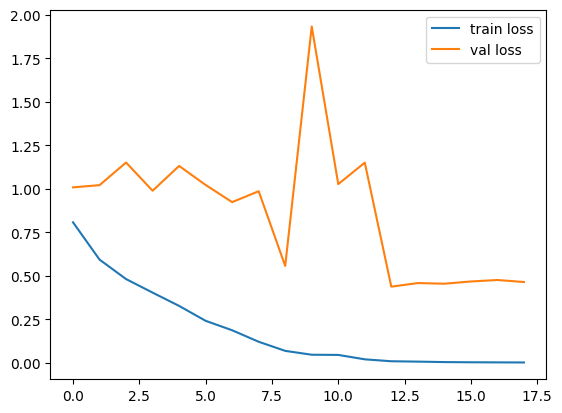

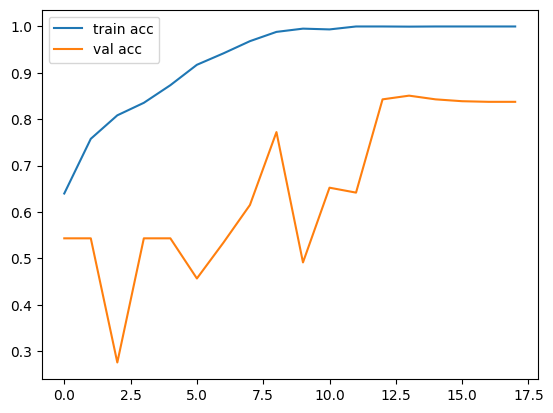

In [77]:
#loss graph
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.savefig('loss-graph.png')
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

In [79]:
# confusion matrix  
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

model.save('model.h5')

14/14 [==============================] - 0s 25ms/step
0.8899521531100478
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       223
           1       0.88      0.85      0.86        67
           2       0.84      0.87      0.85       128

    accuracy                           0.89       418
   macro avg       0.88      0.88      0.88       418
weighted avg       0.89      0.89      0.89       418

[[204   3  16]
 [  5  57   5]
 [ 12   5 111]]


# Build Gradio web app

In [2]:
import gradio as gr
import tensorflow as tf
from PIL import Image
import numpy as np

model = tf.keras.models.load_model("model.h5")

def classify_image(image):
    img = Image.fromarray(image.astype('uint8'), 'RGB')  # Convert to PIL Image
    img = img.resize((100, 100))                       # Resize
    img_array = np.array(img)                          
    img_array = img_array / 255.0                      # Normalize
    img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension

    prediction = model.predict(img_array).flatten()
    return {str(i): float(prediction[i]) for i in range(3)}

image = gr.inputs.Image(shape=(100, 100))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch()


C:\Users\AezersX\AppData\Local\Temp\ipykernel_45668\821007422.py:18: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(100, 100))
C:\Users\AezersX\AppData\Local\Temp\ipykernel_45668\821007422.py:18: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(100, 100))
C:\Users\AezersX\AppData\Local\Temp\ipykernel_45668\821007422.py:19: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=3)
C:\Users\AezersX\AppData\Local\Temp\ipykernel_45668\821007422.py:19: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=3)
C:\Users\AezersX\AppData\Local\Temp\ipy

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 3.50.0, however version 4.29.0 is available, please upgrade.
--------
1/1 [==============================] - 0s 17ms/step
